In [114]:
import pandas as pd
import numpy as np

from datetime import datetime
from pandas_datareader import data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import matplotlib.pyplot as plt

import pandas_datareader
import bs4 as bs
import pickle
import requests

<h2>Downloading of data</h2>

In [2]:
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

tickerList = save_sp500_tickers()
tickerList = [ticker[:-1] for ticker in tickerList]
tickerList = [ticker.replace('.', '-') for ticker in tickerList]
tickerList.append('^GSPC')

In [3]:
end_date = '2019-03-31'
def get_stocks_data(ticker, source, end_date):
    Ticker = pandas_datareader.data.DataReader(ticker, source, end = end_date)
    Ticker['Ticker'] = ticker
    return Ticker
    
stocks_data = [get_stocks_data(ticker, 'yahoo', end_date) for ticker in tickerList]

In [5]:
#We compute the log returns
for stock in stocks_data:
    stock["Log"] = np.log(stock["Adj Close"])
    stock["Returns"] = stock["Log"].diff()
    stock["Returns"][0] = stock["Returns"][1]

stocks_data[0].head()

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,High,Low,Open,Close,Volume,Adj Close,Ticker,Log,Returns
Date,,,,,,,,,
2010-01-04,83.449997,82.669998,83.089996,83.019997,3043700.0,65.798973,MMM,4.186604,-0.006283
2010-01-05,83.230003,81.699997,82.800003,82.500000,2847000.0,65.386833,MMM,4.180321,-0.006283
2010-01-06,84.599998,83.510002,83.879997,83.669998,5268500.0,66.314133,MMM,4.194403,0.014082
2010-01-07,83.760002,82.120003,83.320000,83.730003,4470100.0,66.361694,MMM,4.195120,0.000717
2010-01-08,84.320000,83.300003,83.690002,84.320000,3405800.0,66.829300,MMM,4.202142,0.007022


In [6]:
dfcsv = pd.read_csv('Data/F-F_Research_Data_5_Factors_2x3_daily.csv', header=2, index_col = 0)
dfcsv.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
19630701,-0.67,0.00,-0.32,-0.01,0.15,0.012
19630702,0.79,-0.27,0.27,-0.07,-0.19,0.012
19630703,0.63,-0.17,-0.09,0.17,-0.33,0.012
19630705,0.40,0.08,-0.28,0.08,-0.33,0.012
19630708,-0.63,0.04,-0.18,-0.29,0.13,0.012


<h2>Question1</h2>

In [7]:
#We create a list of dataframe listRegressiondf where each dataframe contains logreturns 
#of a company and coefficient that we will use for our linear regression
listRegressiondf = []
for stock in stocks_data:
    df = stock.loc[:, ['Returns']]
    df = df.reset_index()
    returnArray = df.values
    coeffdf = dfcsv.iloc[-len(df):,:]
    coeffArray = coeffdf.values
    finalArray = np.concatenate([returnArray, coeffArray], axis = 1)
    regressiondf = pd.DataFrame(finalArray, columns = ['Date','logreturns','Mkt-RF','SMB','HML','RMW','CMA','RF'])
    regressiondf = regressiondf.set_index('Date')
    listRegressiondf.append(regressiondf)

listRegressiondf[0].head()

,logreturns,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,
2010-01-04,-0.00628332,1.69,0.75,1.12,-0.22,0.21,0
2010-01-05,-0.00628332,0.31,-0.37,1.22,-0.11,0.18,0
2010-01-06,0.0140821,0.13,-0.16,0.52,-0.03,0.2,0
2010-01-07,0.00071696,0.4,0.24,0.94,-0.62,0.23,0
2010-01-08,0.00702161,0.33,0.34,0.01,0.25,-0.38,0


In [191]:
#We do a loop and a regression on datas of each company
#We store them in an array
coeffArray = []
i = 0
for stock in listRegressiondf:
    X = stock.loc[:,['Mkt-RF','SMB','HML','RMW','CMA','RF']]
    X = X.values
    y = stock.loc[:,'logreturns']
    y = y.values
    reg = LinearRegression().fit(X, y)
    array = reg.coef_
    array = np.append(array,reg.intercept_)
    array = np.append(array, r2_score(y, reg.predict(X)))
    array = np.append(array, tickerList[i])
    coeffArray.append(array)
    i+=1
    
coeffArray = np.array(coeffArray)
coeffdf = pd.DataFrame(coeffArray, columns = ['coeffMkt-RF','coeffSMB','coeffHML','coeffRMW','coeffCMA','coeffRF','constant','R²','Ticker'])
coeffdf.head()

,coeffMkt-RF,coeffSMB,coeffHML,coeffRMW,coeffCMA,coeffRF,constant,R²,Ticker
0,0.010292189473692339,-0.0014985767157733726,-0.0007646786230472078,0.0029789570224156964,0.003617561005104106,-0.03893244957614439,-3.5954431606153095e-06,0.6124243282371491,MMM
1,0.008755589948271528,-0.003262034928812294,-0.004282394025402299,0.0007652840287953594,0.0022380015095530515,0.10839584530655208,-4.3412864600051544e-05,0.44326478279417214,ABT
2,0.010284620655099053,-0.001271230285234439,-0.006658613744345996,-0.0028519337039489387,0.0029434058533642717,-0.13960920785318032,0.00036185794473999775,0.2869047335060543,ABBV
3,0.010616992531446944,0.005155397641298241,-0.010736634208115827,-0.01171459465314883,-0.0014016812239717534,-0.15954328334597273,0.0011252249359401999,0.235830297206444,ABMD
4,0.010544068666227284,-0.0015231490339896864,-0.0014646195704086568,0.002004652736963385,-0.001079052852210636,0.0037965725573560418,0.0001269105617886908,0.5087114360851821,ACN


<h2>Question2</h2>

In [109]:
statsArray = []
index = np.array(['coeffMkt-RF','coeffSMB','coeffHML','coeffRMW','coeffCMA','coeffRF','R²'])
for coeff in coeffArray.transpose():
    statsArray.append([coeff.mean(),coeff.std(),stats.skew(coeff),stats.kurtosis(coeff)])
    
statsArray = np.array(statsArray)
statsdf = pd.DataFrame(statsArray, index = index, columns = ['Mean','std','skew','kurtosis'])
statsdf

,Mean,std,skew,kurtosis
coeffMkt-RF,0.010154,0.002286,-0.511031,2.811038
coeffSMB,0.000755,0.002613,0.433857,0.319243
coeffHML,0.000096,0.004906,1.217401,2.775669
coeffRMW,0.000363,0.004355,-0.697657,1.944863
coeffCMA,0.001696,0.005050,-0.905361,1.938420
coeffRF,-0.006651,0.217990,2.421858,74.822482
R²,0.391185,0.140954,0.458424,0.144940


<h2>Question3</h2>

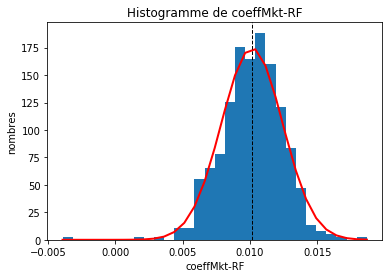

In [166]:
x = coeffArray.transpose()[0]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffMkt-RF')
plt.ylabel('nombres')
plt.title('Histogramme de coeffMkt-RF')
plt.show()

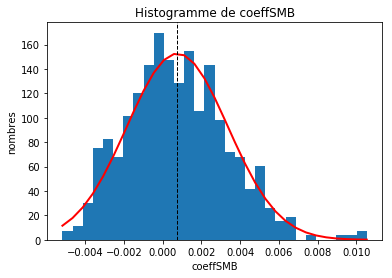

In [167]:
x = coeffArray.transpose()[1]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffSMB')
plt.ylabel('nombres')
plt.title('Histogramme de coeffSMB')
plt.show()

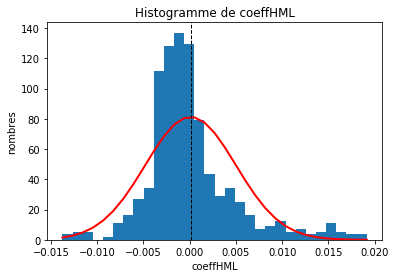

In [168]:
x = coeffArray.transpose()[2]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffHML')
plt.ylabel('nombres')
plt.title('Histogramme de coeffHML')
plt.show()

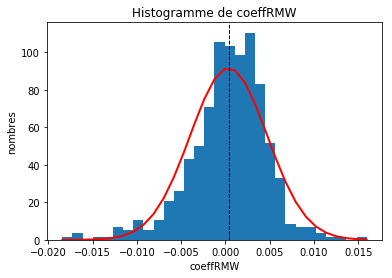

In [169]:
x = coeffArray.transpose()[3]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffRMW')
plt.ylabel('nombres')
plt.title('Histogramme de coeffRMW')
plt.show()

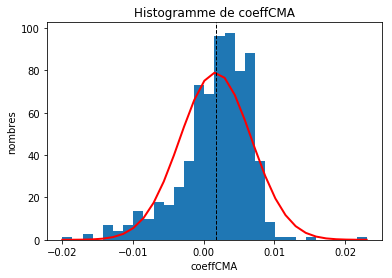

In [170]:
x = coeffArray.transpose()[4]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffCMA')
plt.ylabel('nombres')
plt.title('Histogramme de coeffCMA')
plt.show()

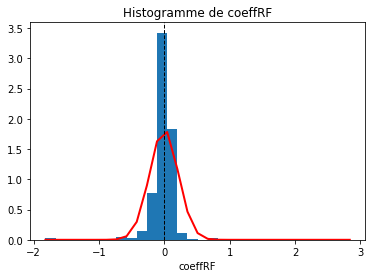

In [176]:
x = coeffArray.transpose()[5]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('coeffRF')
plt.title('Histogramme de coeffRF')
plt.show()

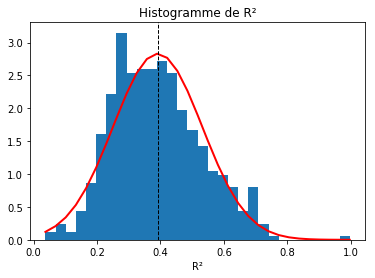

In [178]:
x = coeffArray.transpose()[6]
sigma = np.std(x)
mu = np.mean(x)
count, bins, ignored = plt.hist(x, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlabel('R²')
plt.title('Histogramme de R²')
plt.show()

Coefficients and R² have a distribution near to a gaussian distribution.

<h2>Question4</h2>

In [215]:
sortdf = coeffdf[['constant','Ticker']]
sortdf['constant'] = sortdf['constant']
sortdf = sortdf.sort_values(by = 'constant')
sortdf.head()

C:\Users\Hugo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,constant,Ticker
128,-0.00010147035814644234,CXO
462,-0.00010245599969682938,UPS
360,-0.00010342659537206995,OMC
352,-0.00011021233089180131,NTRS
426,-0.00011470732289854438,STT


In [210]:
print("The five companies withe the lowest constant are:")
for i in sortdf.iloc[:5]['Ticker']:
    print(i)

The five company withe the lowest constant are:
CXO
UPS
OMC
NTRS
STT


In [213]:
print("The five companies withe the highest constant are:")
for i in sortdf.iloc[-5:]['Ticker']:
    print(i)

The five company withe the highest constant are:
CCI
TMO
PM
AMT
FOXA
